In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
IMAGE_SIZE = 32
mean, std = [0.4465], [0.261]
# source: https://pytorch.org/vision/stable/transforms.html
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)


transforms_test = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transforms_train
)
validation_dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transforms_test
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=512, num_workers=31, persistent_workers=True
)
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=512, num_workers=31, persistent_workers=True
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 31 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


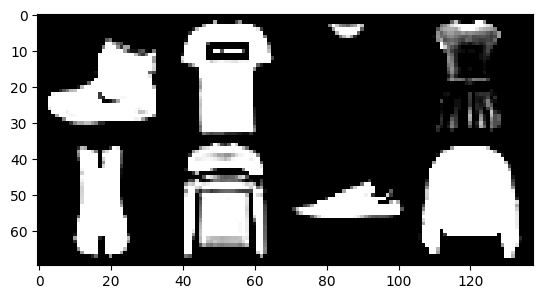

In [4]:
# show some train images
import matplotlib.pyplot as plt
import numpy as np


def show_img(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


images, labels = next(iter(train_loader))
show_img(torchvision.utils.make_grid(images[:8], nrow=4, padding=2))

In [5]:
# model_utils.py
import torch
import torch.nn as nn
import lightning as L
import torchmetrics
from torchvision.models.resnet import wide_resnet50_2


TASK = "multiclass"
NUM_CLASSES = 10


class _BNReLUConv(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride, padding, dropout
    ):
        super().__init__()
        self.add_module("bn", nn.BatchNorm2d(in_channels))
        self.add_module("relu", nn.ReLU(inplace=True))
        self.add_module(
            "conv",
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
        )
        if dropout and dropout > 0:
            self.add_module("drop", nn.Dropout2d(p=dropout))


class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, dropout):
        super().__init__()
        self.branch = _BNReLUConv(
            in_channels,
            growth_rate,
            kernel_size=3,
            stride=1,
            padding=1,
            dropout=dropout,
        )

    def forward(self, x):
        out = self.branch(x)
        return torch.cat([x, out], dim=1)


class Transition(nn.Sequential):
    def __init__(self, in_channels, out_channels, dropout):
        super().__init__()
        self.add_module("bn", nn.BatchNorm2d(in_channels))
        self.add_module("relu", nn.ReLU(inplace=True))
        self.add_module(
            "conv",
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False,
            ),
        )
        if dropout and dropout > 0:
            self.add_module("drop", nn.Dropout2d(p=dropout))
        self.add_module("pool", nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    def __init__(
        self, depth=40, first_output=16, growth_rate=12, dropout=0.2, num_classes=10
    ):
        super().__init__()
        assert (depth - 4) % 3 == 0, "depth must be 3n+4"
        num_layers_per_block = (depth - 4) // 3

        self.conv1 = nn.Conv2d(
            1, first_output, kernel_size=3, stride=1, padding=1, bias=False
        )
        num_channels = first_output

        self.block1 = self._make_dense_block(
            num_layers_per_block, num_channels, growth_rate, dropout
        )
        num_channels += num_layers_per_block * growth_rate
        self.trans1 = Transition(num_channels, num_channels, dropout)

        self.block2 = self._make_dense_block(
            num_layers_per_block, num_channels, growth_rate, dropout
        )
        num_channels += num_layers_per_block * growth_rate
        self.trans2 = Transition(num_channels, num_channels, dropout)

        self.block3 = self._make_dense_block(
            num_layers_per_block, num_channels, growth_rate, dropout
        )
        num_channels += num_layers_per_block * growth_rate

        self.bn = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_channels, num_classes)

    def _make_dense_block(self, num_layers, in_channels, growth_rate, dropout):
        layers = []
        for i in range(num_layers):
            layers.append(
                DenseLayer(in_channels + i * growth_rate, growth_rate, dropout)
            )
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.trans1(x)
        x = self.block2(x)
        x = self.trans2(x)
        x = self.block3(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)
        return logits


class DenseNetLit(L.LightningModule):
    def __init__(self, hyperparameters):
        """
        Example hyperparameters:
        depth=40, first_output=16, growth_rate=12, dropout=0.2
        hyperparameters = {
            "depth": 40,
            "first_output": 16,
            "growth_rate": 12,
            "dropout": 0.2,
        }
        """
        super().__init__()
        self.model = DenseNet(
            hyperparameters["depth"],
            hyperparameters["first_output"],
            hyperparameters["growth_rate"],
            hyperparameters["dropout"],
            num_classes=NUM_CLASSES,
        )
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.train_metrics = torchmetrics.MetricCollection(
            {
                "f1_macro": torchmetrics.F1Score(
                    task=TASK, num_classes=NUM_CLASSES, average="macro"
                ),
                "precision": torchmetrics.Precision(
                    task=TASK, num_classes=NUM_CLASSES, average="macro"
                ),
                "recall": torchmetrics.Recall(
                    task=TASK, num_classes=NUM_CLASSES, average="macro"
                ),
                "auroc": torchmetrics.AUROC(
                    task=TASK, num_classes=NUM_CLASSES, average="macro"
                ),
                "accuracy": torchmetrics.Accuracy(task=TASK, num_classes=NUM_CLASSES),
            },
            prefix="train_",
        )
        self.val_metrics = self.train_metrics.clone(prefix="val_")
        self.test_metrics = self.train_metrics.clone(prefix="test_")
        self.train_batch_outputs = []
        self.val_batch_outputs = []
        self.test_batch_outputs = []
        self.hyperparameters = hyperparameters

    def on_train_start(self):
        if self.logger is not None:
            self.logger.log_hyperparams(self.hyperparameters)

    def on_test_start(self):
        if self.logger is not None:
            self.logger.log_hyperparams(self.hyperparameters)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        probabilities = torch.softmax(logits, dim=1)
        self.train_batch_outputs.append({"probabilities": probabilities, "y": y})
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log(
            "lr", self.optimizers().param_groups[0]["lr"], on_step=True, on_epoch=True
        )
        return loss

    def on_train_epoch_end(self):
        probabilities = torch.cat(
            [x["probabilities"] for x in self.train_batch_outputs]
        )
        y = torch.cat([x["y"] for x in self.train_batch_outputs])
        metrics = self.train_metrics(probabilities, y)
        self.log_dict(metrics)
        self.train_metrics.reset()
        self.train_batch_outputs.clear()

    def validation_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        probabilities = torch.softmax(logits, dim=1)
        self.val_batch_outputs.append({"probabilities": probabilities, "y": y})
        self.log("val_loss", loss, on_step=True, on_epoch=True)
        return loss

    def on_validation_epoch_end(self):
        probabilities = torch.cat([x["probabilities"] for x in self.val_batch_outputs])
        y = torch.cat([x["y"] for x in self.val_batch_outputs])
        metrics = self.val_metrics(probabilities, y)
        self.log_dict(metrics)
        self.val_metrics.reset()
        self.val_batch_outputs.clear()

    def test_step(self, batch):
        x, y = batch
        logits = self(x)
        probabilities = torch.softmax(logits, dim=1)
        self.test_batch_outputs.append({"probabilities": probabilities, "y": y})

    def on_test_epoch_end(self):
        probabilities = torch.cat([x["probabilities"] for x in self.test_batch_outputs])
        y = torch.cat([x["y"] for x in self.test_batch_outputs])
        metrics = self.test_metrics(probabilities, y)
        self.log_dict(metrics)
        self.test_metrics.reset()
        self.test_batch_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.model.parameters(), lr=0.1, weight_decay=10e-6, momentum=0.9
        )
        total_steps = self.trainer.estimated_stepping_batches
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer,
            max_lr=4.0,
            total_steps=total_steps,
            div_factor=40,
            final_div_factor=40,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
                "strict": False,
            },
        }


class WideResnetLit(DenseNetLit):
    def __init__(self, hyperparameters):
        super().__init__(hyperparameters)
        self.model = wide_resnet50_2(pretrained=False, num_classes=NUM_CLASSES)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.model.parameters(), lr=0.1, weight_decay=10e-4, momentum=0.9
        )
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer,
            max_lr=1.0,
            steps_per_epoch=98,
            epochs=50,
            div_factor=10,
            final_div_factor=10,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
                "strict": False,
            },
        }

In [ ]:
# from model_utils import DenseNetLit
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger

torch.set_float32_matmul_precision("medium")

In [ ]:
# pip install -U 'mlflow>=2.22.0'

In [8]:
class DataModule(L.LightningDataModule):
    def __init__(self, train_loader, validation_loader):
        super().__init__()
        self.train_loader = train_loader
        self.validation_loader = validation_loader

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.validation_loader


data = DataModule(train_loader, validation_loader)
hyperparameters = {
    "depth": 40,
    "first_output": 16,
    "growth_rate": 12,
    "dropout": 0.2,
}
model = DenseNetLit(hyperparameters=hyperparameters)
logger = MLFlowLogger(experiment_name="DenseNet", save_dir="mlruns")
trainer = L.Trainer(
    max_epochs=50,
    logger=logger,
    callbacks=[
        ModelCheckpoint(
            monitor="val_f1_macro",
            mode="max",
            dirpath="checkpoints/densenet",
            filename="{epoch:02d}-{val_f1_macro:.3f}-{val_accuracy:.3f}",
        )
    ],
    precision="16-mixed",
    num_sanity_val_steps=0,
)
trainer.fit(model, datamodule=data)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | DenseNet         | 1.0 M  | t

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 31 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


At epoch 49 validation f1 macro score is 0.941 while training with max_epochs=50

In [9]:
#!mlflow ui

[2025-05-29 19:29:51 +0000] [5313] [INFO] Starting gunicorn 23.0.0
[2025-05-29 19:29:51 +0000] [5313] [INFO] Listening at: http://127.0.0.1:5000 (5313)
[2025-05-29 19:29:51 +0000] [5313] [INFO] Using worker: sync
[2025-05-29 19:29:51 +0000] [5314] [INFO] Booting worker with pid: 5314
[2025-05-29 19:29:51 +0000] [5315] [INFO] Booting worker with pid: 5315
[2025-05-29 19:29:51 +0000] [5316] [INFO] Booting worker with pid: 5316
[2025-05-29 19:29:51 +0000] [5317] [INFO] Booting worker with pid: 5317

Aborted!
[2025-05-29 19:32:44 +0000] [5313] [INFO] Handling signal: int
[2025-05-29 19:32:44 +0000] [5316] [INFO] Worker exiting (pid: 5316)
[2025-05-29 19:32:44 +0000] [5317] [INFO] Worker exiting (pid: 5317)
[2025-05-29 19:32:44 +0000] [5315] [INFO] Worker exiting (pid: 5315)
[2025-05-29 19:32:44 +0000] [5314] [INFO] Worker exiting (pid: 5314)
[2025-05-29 19:32:44 +0000] [5313] [INFO] Shutting down: Master
^C


In [ ]:
from google.colab import files
import shutil

shutil.make_archive("mlruns", "zip", "mlruns")
files.download("mlruns.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>